In [1]:
import matplotlib.pyplot as plt
import paraview.simple as pvs
import pandas as pd
import numpy as np
import math
from pathlib import Path


# Biocellion Output Plotting
This notebook defines functions to read and plot the biocellion output data for the Biocellion ABM models by the CMMC that can be found in github.com/TheCMMC. For more information on the CMMC, visit www.thecmmc.org.  

To use these plotting functions the biocellion output summary should be in one directory with the following naming pattern:
`output_parameter{par_id}_trial{trial}.txt`

If the scripts and instructions in https://github.com/TheCMMC/biocellion-tools have been used to create the output, this notebook should be able to run with the resulting data.

## User settings

In [2]:
# Set this data folder to the place where you cloned the repository https://github.com/TheCMMC/biocellion-data
DATA_FOLDER = Path("/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/biocellion-data")
MODEL_FOLDER = Path("/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user")
FIG_FOLDER = Path("./figures")

In [3]:
ABM_ONLY_DATA_FOLDER = DATA_FOLDER / "PLOSone_ABM-only-microcarrier"
ABM_ONLY_MODEL_FOLDER = MODEL_FOLDER / "ABM-only-microcarriers"
ABM_ONLY_PAR_FILENAME = ABM_ONLY_MODEL_FOLDER / "Parameters-ABM-Only.csv"

ABM_CFD_DATA_FOLDER = DATA_FOLDER / "PLOSone_ABM-CFD-microcarrier"
ABM_CFD_MODEL_FOLDER = MODEL_FOLDER / "ABM-microcarriers"
ABM_CFD_PVTP_FOLDER = ABM_CFD_MODEL_FOLDER / "output_first_manuscript"
ABM_CFD_PAR_FILENAME = ABM_CFD_DATA_FOLDER / "Parameters-ABM-CFD.csv"

In [4]:
COLOR_DICT={'live': '#1f77b4', 'attached': '#2ca02c', 'dead': '#ff7f0e', 'removed': '#d62728'}
HATCH_DICT= {'live': '//', 'attached': '..', 'dead': '--', 'removed': '\\\\'}
# to use the hatch dict: ax.fill_between(..., hatch=HATCH_DICT[state])

## Plotting functions

In [5]:
def read_parameter_file(filename):
    par_df = pd.read_csv(filename, index_col=0, header=2, skiprows=range(3,7), usecols=(lambda x: x not in str(list(range(11)))))
    return par_df
    
def read_summary_file(par_id, trial, data_folder, states=["live", "attached", "dead", "removed"]):
    filename = data_folder / f"output_parameter{par_id}_trial{trial}.txt"
    live, attached, dead, removed = ([],[],[],[])

    with open(filename, 'r' ) as f :
        for line in f:
            if 'Live Cells' in line :
              live.append( int( line.strip().split(':')[-1] ) )
            if 'Live Attached Cells' in line :
              attached.append( int( line.strip().split(':')[-1] ) )
            elif 'Death Cells' in line:
              dead.append( int( line.strip().split(':')[-1] ))
            elif 'Removed Cells' in line :
              removed.append( int( line.strip().split(':')[-1] ))
    
    # if the lengths of these list are different print error
    assert len(live)==len(attached)==len(dead)==len(removed), "Cell count lists are of different lenghts"
    
    return pd.DataFrame({"live":live, "attached":attached, "dead":dead, "removed":removed})[states]

def load_parameter_set(par_id, data_folder, trials=range(1,11), as_dict=False, states=["live", "attached", "dead", "removed"]):
    par_set = []
    for trial in trials:
        trial_data = read_summary_file(par_id, trial, data_folder, states=states)
        par_set.append(trial_data)
    if as_dict:
        par_set=dict(zip(trials,par_set))
    return par_set

def compute_statistics(par_set):
    par_set = pd.concat(par_set)
    grouped_par_set = par_set.groupby(par_set.index)
    means = grouped_par_set.mean()
    stds = grouped_par_set.std()
    stds = grouped_par_set.std()
    return means, stds

def plot_trials(par_id, data_folder, trials=range(1,11), states=["live", "attached", "dead", "removed"], ax=None, legend=True):
    if ax==None:
        fig, ax = plt.subplots()
    par_set = load_parameter_set(par_id, data_folder, trials=trials, as_dict=True)
    if legend:
        legend = ax.legend(loc='upper left')
    for trial in trials:        
        par_set[trial].plot(ax=ax, alpha=.5, legend=legend, color=COLOR_DICT)
        ax.set_prop_cycle(None)
        legend=None

        

def plot_stats(par_id, data_folder, states=["live", "attached", "dead", "removed"], ax=None, legend=True, par_box=False):
    if ax==None:
        fig, ax = plt.subplots(dpi=300)
    par_set = load_parameter_set(par_id, data_folder, states=states)
    means, stds = compute_statistics(par_set)
    under_line     = (means-stds)
    over_line      = (means+stds)
    means.plot(ax=ax, label=means.columns, color=COLOR_DICT)
    
    for state in states:
        ax.fill_between(stds.index, under_line[state], over_line[state], alpha=.3, color=COLOR_DICT[state])
    ax.title.set_text(f"Statistics of parameter set {par_id}" )
    
    if legend:
        ax.legend(loc='center left')
    
    if par_box:
        par_df = read_parameter_file(ABM_CFD_PAR_FILENAME)
        par_str = ""
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        for par in par_df.columns:
            par_str += f"{par}: {par_df.at[par_id, par]}\n"
        ax.text(0.05, 0.95, par_str, transform=ax.transAxes, verticalalignment='top', bbox=props, size=8)
        
def plot_compare_rpms(par_ids, data_folder, states=["live", "attached", "dead", "removed"], ylim=[None,None], par_box=False):
    prows = math.ceil(len(par_ids)/2)
    fig, axs = plt.subplots(prows, 2, figsize=(20, 5*prows), sharey="row", dpi=300)
    axs=axs.flatten()
    for i, par_id in enumerate(par_ids): 
        plot_stats(par_id, data_folder, ax=axs[i], states=states, par_box=par_box)
        axs[i].set_ylim(ylim)
    plt.savefig(FIG_FOLDER / f"compare_rpms_parid_{par_ids[0]}-{par_ids[-1]}.png")


In [6]:
par_df = read_parameter_file(ABM_CFD_PAR_FILENAME)
# print(par_df)

In [7]:
cell_counts = read_summary_file(17, 8, ABM_CFD_DATA_FOLDER)
# cell_counts.plot(color=COLOR_DICT)

In [8]:
for i in range(5,5):
    fig, ax = plt.subplots(1,2,figsize=(20, 5))
    plot_trials(i, ABM_CFD_DATA_FOLDER, ax=ax[0], legend=False)
    plot_stats(i, ABM_CFD_DATA_FOLDER, ax=ax[1], legend=True)


In [9]:
#plot_compare_rpms(range(5,19), ABM_CFD_DATA_FOLDER, states=["live", "attached", "dead", "removed"], ylim=[-10,400], par_box=True)

## Plotting agent stress

In [10]:
from paraview import servermanager as sm
from paraview.vtk.numpy_interface import dataset_adapter as dsa

def read_pvtp_files(pvtp_folder, time_range):
    pvs._DisableFirstRenderCameraReset()
    df_step_dict = {}
    
    for step in time_range:
        file_name = pvtp_folder / f'agent_{str(step).zfill(6)}.pvtp'
#         print(file_name)
        assert file_name.exists()
        reader = pvs.XMLPartitionedPolydataReader(FileName = str(file_name))
        vtk_data = sm.Fetch(reader)
        
        object_data = dsa.WrapDataObject(vtk_data)
        data = object_data.GetPointData()
        cell_df = pd.DataFrame()
        
        for i, name in enumerate(data.keys()):
            cell_df[name]=data.GetArray(i)
            
        pvs.Delete(reader)
        df_step_dict[step] = cell_df
        
    return df_step_dict

def compute_cell_statistics(df_step_dict):
    means = pd.DataFrame()
    stds = pd.DataFrame()
    for step in df_step_dict.keys():
        mean = df_step_dict[step].mean()
        mean_df = pd.DataFrame(mean, columns=[step]).transpose()
        means = means.append(mean_df)
        
        std =  df_step_dict[step].std()
        std_df = pd.DataFrame(std, columns=[step]).transpose()
        stds = stds.append(std_df)
        
    return means, stds

def plot_cells_hist(par_id, trial, key, step, pvtp_folder):
    pvtp_folder = pvtp_folder / f"output_parameter{par_id}_trial{trial}"
    df_step_dict = read_pvtp_files(pvtp_folder, [step])
    cell_df = df_step_dict[step]
    cell_df[key].plot.hist(bins=100)
    plt.savefig(FIG_FOLDER / f"cell_hist_{key}_{par_id}_{trial}_{step}.png")
    
def plot_cells_stats(par_id, key, data_folder, trials=range(1,11), time_range=range(0, 120000, 2000), ax=None, par_box=False):
    if ax==None:
        fig, ax = plt.subplots()
    df_step_dict = {step:pd.DataFrame() for step in time_range}
    
    for trial in trials:
        pvtp_folder = data_folder / f"output_parameter{par_id}_trial{trial}"
        single_trial = read_pvtp_files(pvtp_folder, time_range)
        for step in time_range:
            df_step_dict[step] = pd.concat([df_step_dict[step], single_trial[step]], )

    means, stds = compute_cell_statistics(df_step_dict)
    under_line     = (means-stds)[key]
    over_line      = (means+stds)[key]
    means[key].plot(ax=ax, label=key)
    ax.fill_between(stds.index, under_line, over_line, alpha=.3)
    ax.title.set_text(f"Mean {key} for parameter set {par_id}" )
    
    if par_box:
        par_df = read_parameter_file(ABM_CFD_PAR_FILENAME)
        par_str = ""
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        for par in par_df.columns:
            par_str += f"{par}: {par_df.at[par_id, par]}\n"
        ax.text(0.05, 0.95, par_str, transform=ax.transAxes, verticalalignment='top', bbox=props, size=8)
    
def plot_cells_compare_rpms(par_ids, key, data_folder, trials=range(1,11), time_range=range(0, 120000, 2000), ylim=[None,None], par_box=False):
    prows = math.ceil(len(par_ids)/2)
    fig, axs = plt.subplots(prows, 2, figsize=(20, 5*prows), sharey="row")
    axs=axs.flatten()
    for i, par_id in enumerate(par_ids): 
        plot_cells_stats(par_id, key, data_folder, trials=trials, time_range=time_range, ax=axs[i], par_box=par_box)
        axs[i].set_ylim(ylim)
    plt.savefig(FIG_FOLDER / f"compare_{key}_{par_ids[0]}-{par_ids[-1]}.png")

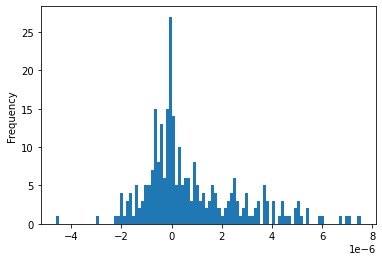

In [11]:
plot_cells_hist(6, 5, "stress", 100000, ABM_CFD_PVTP_FOLDER)

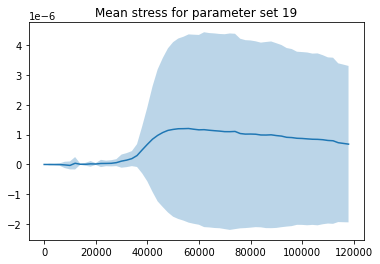

In [12]:
plot_cells_stats(19, "stress", ABM_CFD_PVTP_FOLDER)

In [13]:
#plot_cells_compare_rpms(range(19,33), "stress", ABM_CFD_PVTP_FOLDER, trials=range(1,11), time_range=range(0, 120000, 2000), ylim=[-2.0E-6, 4.0E-6], par_box=True)

## Plot cell distribution

In [91]:
from paraview import servermanager as sm
from paraview.vtk.numpy_interface import dataset_adapter as dsa
from tqdm.notebook import tqdm
import matplotlib.colors as colors

def read_pvtp_files(pvtp_folder, time_range, filter_key=None, filter_val=None, by_step=False, step_digits=None, progress=False):
    pvs._DisableFirstRenderCameraReset()
    multi_step_df = pd.DataFrame()
    if progress:
        time_range = tqdm(time_range)
    for step in time_range:
        if step_digits:
            digits = step_digits
        else:
            digits = len(str(max(time_range)))
        
        file_name = pvtp_folder / f'agent_{str(step).zfill(digits)}.pvtp'
        try:
            assert file_name.exists()
        except AssertionError:
            print(f"{file_name} does not exist")
            pass
        reader = pvs.XMLPartitionedPolydataReader(FileName = str(file_name))
        vtk_data = sm.Fetch(reader)
        
        object_data = dsa.WrapDataObject(vtk_data)
        data = object_data.GetPointData()
        agent_df = pd.DataFrame()
        
        for i, name in enumerate(data.keys()):
            agent_df[name]=data.GetArray(i)
        
        points = object_data.Points

        for i, coord in enumerate(["x","y","z"]):
            agent_df[coord]=np.transpose(points)[i]

        pvs.Delete(reader)
  
        if by_step:
            agent_df["step"]=step
            agent_df.set_index("step", drop=True, inplace=True)    
        
        if filter_key and filter_val:
            agent_df = agent_df[agent_df[filter_key]==filter_val]

        multi_step_df = multi_step_df.append(agent_df)
                    
    return multi_step_df


def load_all_simulations(output_folder, par_ids, trials):
    multi_sim_df = pd.DataFrame()
    for par_id in par_ids:
        for trial in trials:
            pvtp_folder = output_folder / f"output_parameter{par_id}_trial{trial}"
            try:
                multi_step_df = read_pvtp_files(pvtp_folder, range(0, 120000, 2000), filter_key="radius", filter_val=75.0, by_step=True)
            except:
                continue
            multi_step_df["par_id"]=par_id
            multi_step_df["trial"]=trial
            multi_step_df["r"] = np.sqrt(np.power((multi_step_df["x"] - 28000) ,2) + np.power((multi_step_df["y"] - 28000) ,2))
            multi_sim_df = multi_sim_df.append(multi_step_df)
    return multi_sim_df


def load_particle_tracing(output_folder, rpm, steps, progress=False):
    pvtp_folder = output_folder / f"output_mc_only_{rpm}"
    multi_step_df = read_pvtp_files(pvtp_folder, range(0, steps, 2000), filter_key="radius", filter_val=75.0, by_step=True, step_digits=7, progress=progress)
    multi_step_df["r"] = np.sqrt(np.power((multi_step_df["x"] - 28000) ,2) + np.power((multi_step_df["y"] - 28000) ,2))
    return multi_step_df


def draw_vessel(vessel=True, impeller = True, color="w", ax=None):
    ves_h=43000; ves_r=27650
    if vessel:
        vessel_points = [[-ves_r,0], [ves_r,0], [ves_r,ves_h], [-ves_r,ves_h]]
        vessel_bound = plt.Polygon(vessel_points, fill=None, edgecolor=color)
        if ax:
            ax.add_patch(vessel_bound)
        else:
            plt.gca().add_patch(vessel_bound)
    
    if impeller:
        ax_r=500; rod_h=8000; rod_l=19000; rod_off=10000
        impeller_points = [[-rod_l, rod_off], [rod_l, rod_off], 
                           [rod_l, rod_off+rod_h], [ax_r, rod_off+rod_h], 
                           [ax_r, ves_h], [-ax_r, ves_h], 
                           [-ax_r, rod_off+rod_h], [-rod_l, rod_off+rod_h]]
        impeller = plt.Polygon(impeller_points, fill=None, edgecolor=color)
        if ax:
            ax.add_patch(impeller)
        else:
            plt.gca().add_patch(impeller)        

            
def plot_mc_distribution(step, rpm, data, n_steps=None, n_bins=100, plot_type="heatmap", 
                         include_vessel=True, gamma=1, vmax=None, ax=None, colorbar = False,
                         save_fig=True):
    if ax==None:
        fig, ax = plt.subplots(dpi=300)
    ax.set_aspect('equal', adjustable='box')         
    ax.title.set_text(f"{step}" )
    
    min_step = step-n_steps if (n_steps and step-n_steps > 0) else None
    print(min_step)
    data = data.loc[min_step:step]
    domain = [0, 27500, 0, 42895]
    aspect = domain[3]/domain[1]
    extent = [domain[0], domain[1]+1000, domain[2], domain[3]+1000]
    
    color_dict = {"heatmap":"w", "scatter":"k"}
      
    if plot_type=="heatmap":    
        heatmap, xedges, yedges = np.histogram2d(data["r"], data["z"], 
                                                 bins=[n_bins, int(n_bins*aspect)], 
                                                 range=[extent[0:2],extent[2:4]])
        im = ax.imshow(heatmap.T,  origin='lower', cmap="inferno", norm=colors.PowerNorm(gamma=gamma, vmax=vmax), extent=extent, aspect=1)
#         im = ax.imshow(heatmap.T,  vmax = 100, origin='lower', cmap="inferno", extent=extent, aspect=1)
        if colorbar:
            plt.colorbar(im, ax=ax)
    
    elif plot_type=="scatter":
        size = 1000/data.shape[0]
        ax.scatter(data[["r"]],data[["z"]], s=size, c="#f8484b3b")
        ax.set_xlim(extent[0:2])
        ax.set_ylim(extent[2:4])
            
    if include_vessel:
        draw_vessel(color=color_dict[plot_type], ax=ax)

    if save_fig==True:
        plt.savefig(FIG_FOLDER / f"mc_distribution_{plot_type}_{step}_{rpm}.png")

In [15]:
par_ids = range(5, 33, 2)
trials = range(1, 11)

agent_data = load_all_simulations(ABM_CFD_PVTP_FOLDER, par_ids, trials)

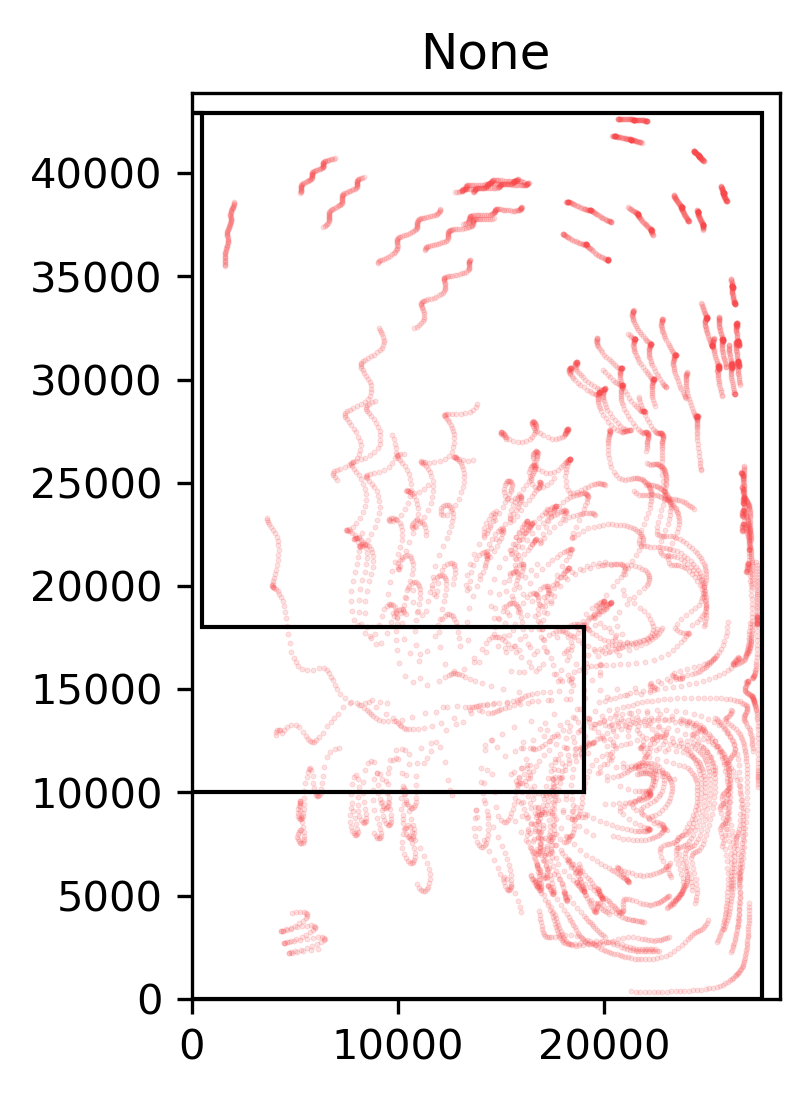

In [17]:
step=None
rpm = 60
plot_mc_distribution(step, rpm, agent_data, n_steps = None, plot_type="scatter")

In [18]:
rpm = 60
mc_data = load_particle_tracing(ABM_CFD_MODEL_FOLDER, rpm, 1800000)

400000


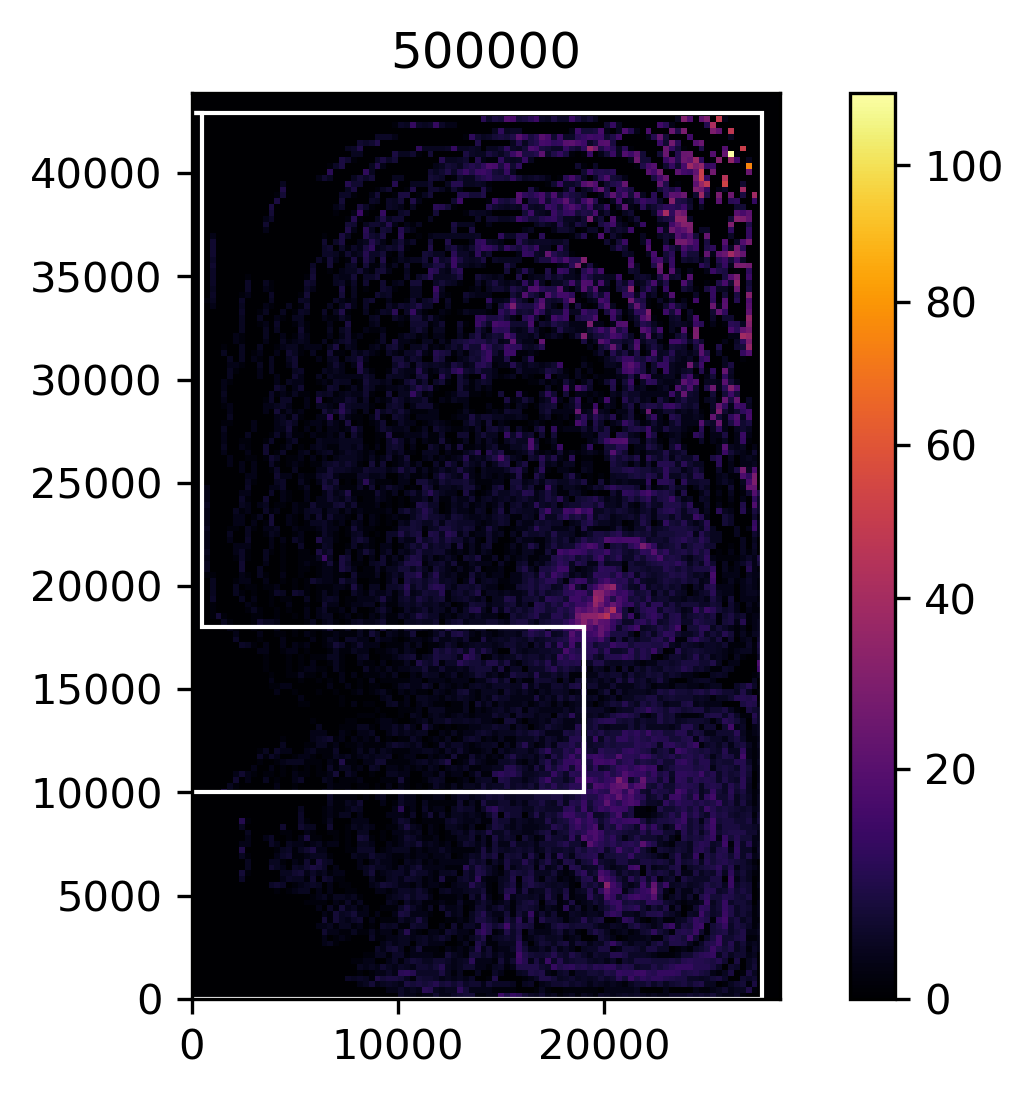

In [36]:
step=500000
n_steps = 100000
# plot_mc_distribution(step, rpm, mc_data, n_steps=n_steps, plot_type="scatter", save_fig=False)
plot_mc_distribution(step, rpm, mc_data, n_bins = 100, n_steps = n_steps, plot_type="heatmap")

In [49]:
mc_data_60 = load_particle_tracing(ABM_CFD_MODEL_FOLDER, 60, 1800000, progress=True)
mc_data_220 = load_particle_tracing(ABM_CFD_MODEL_FOLDER, 220, 1800000, progress=True)


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

None
380000
880000
1380000
None
380000
880000
1380000


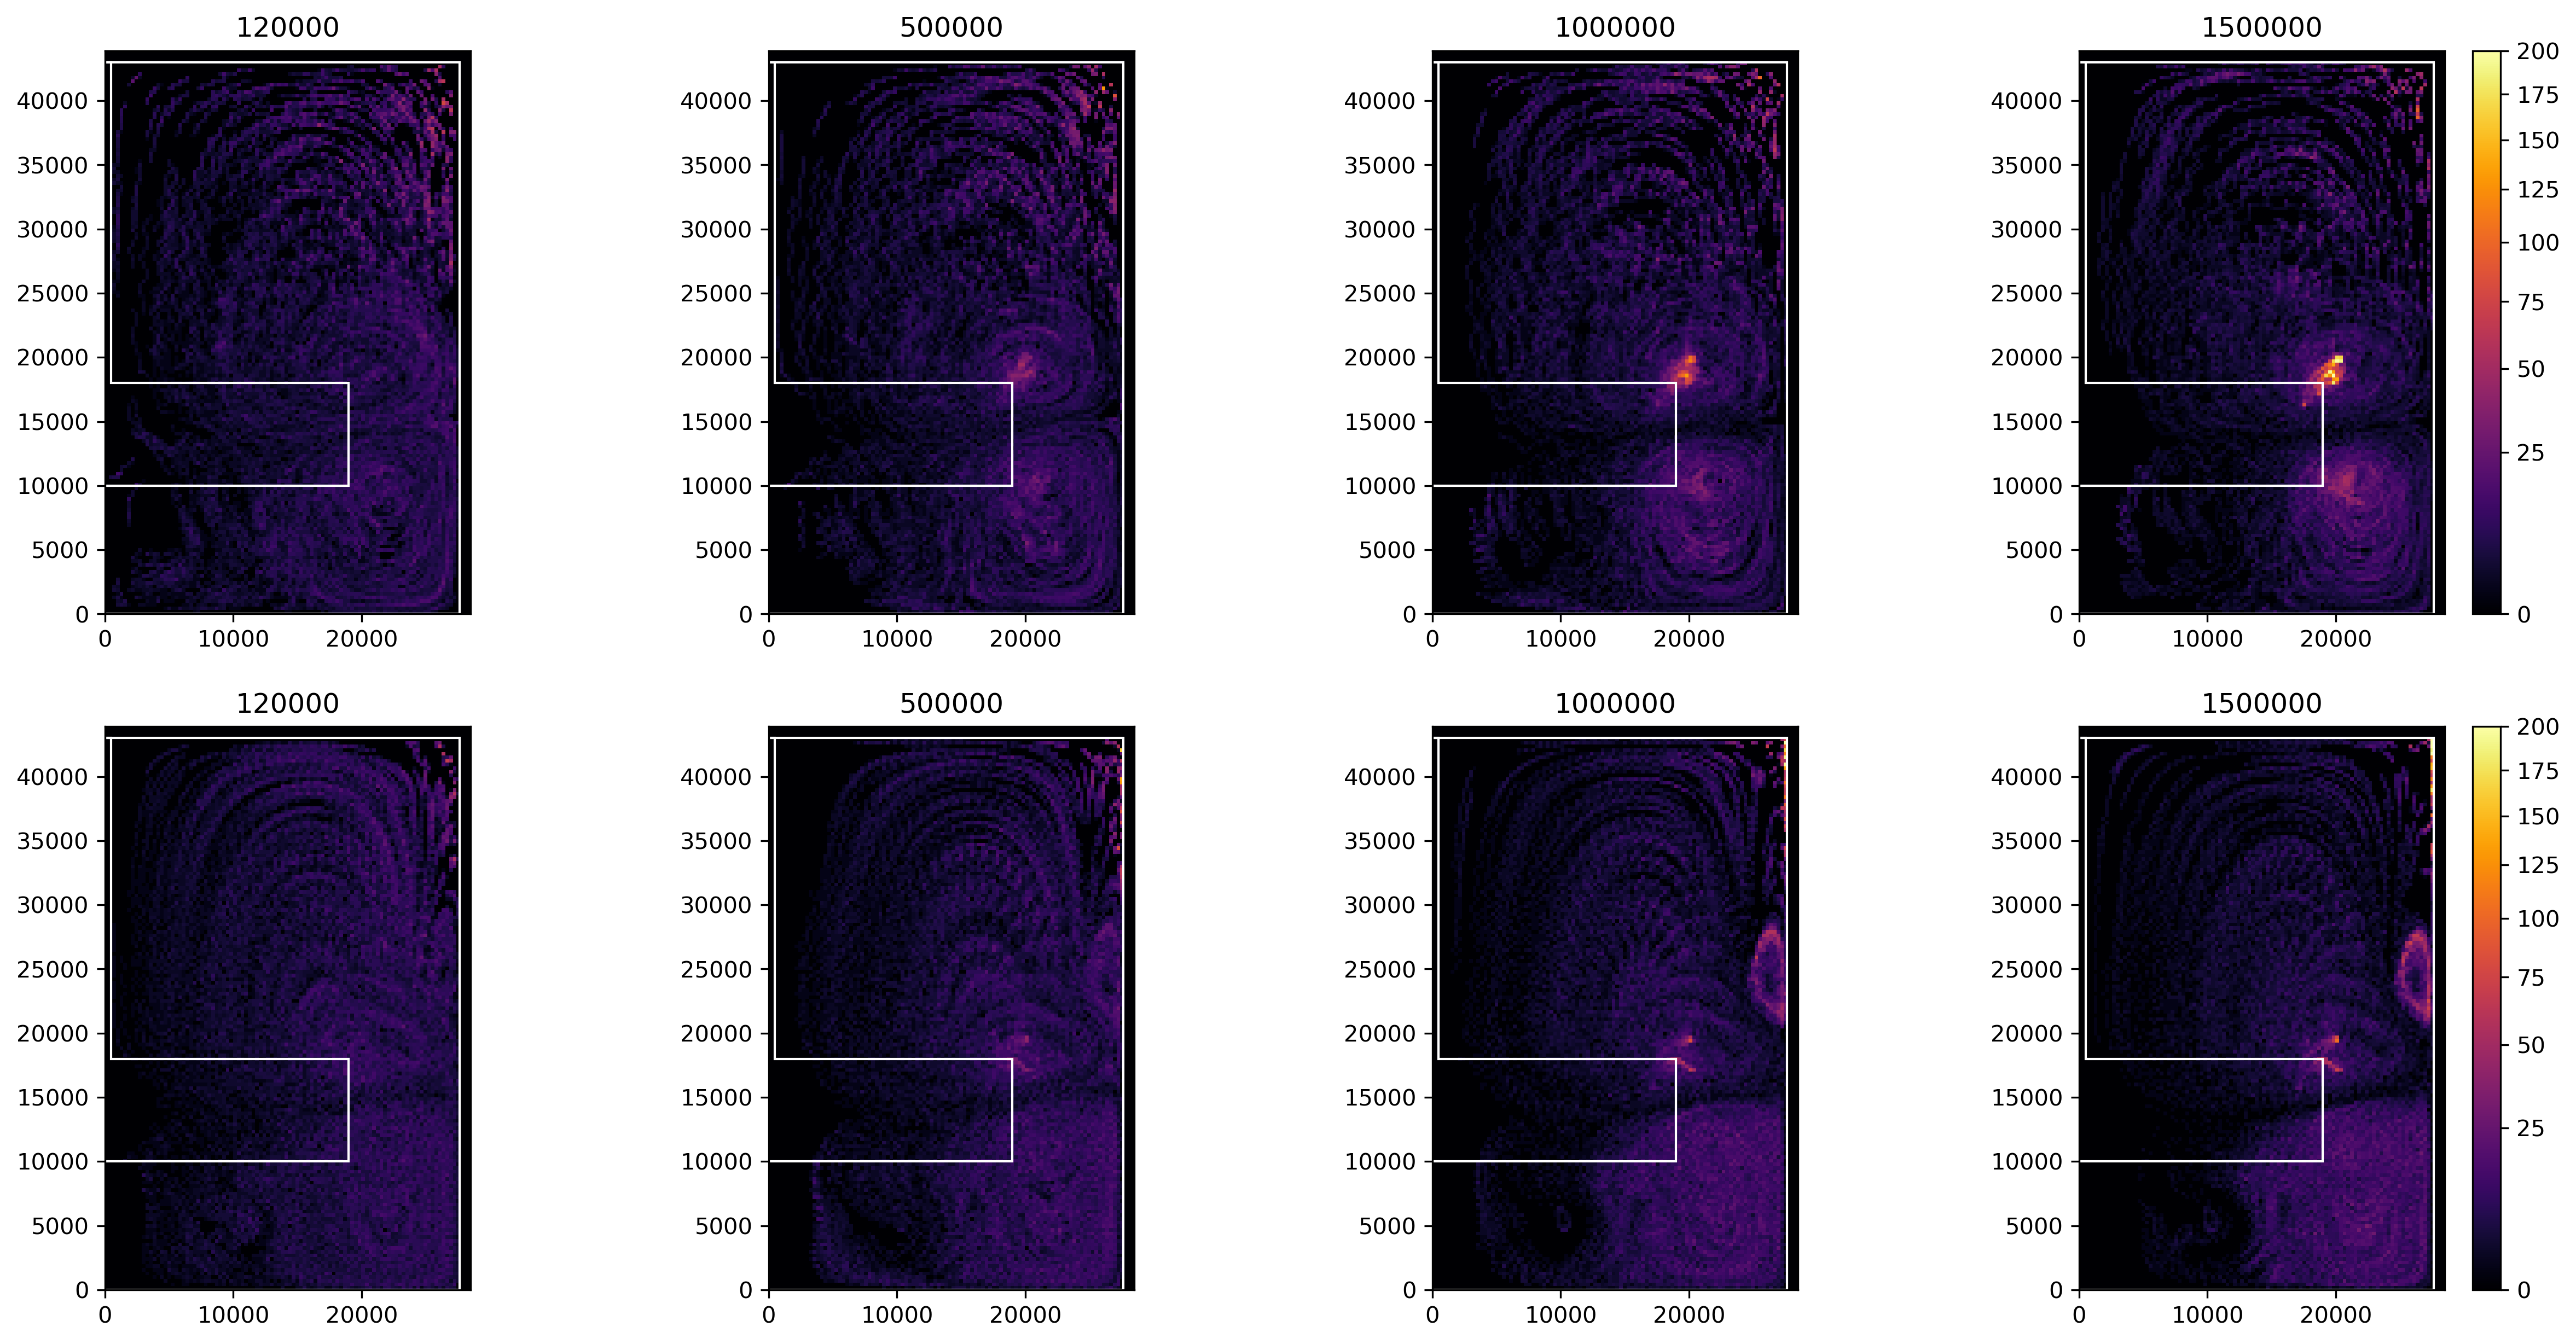

In [92]:
sim_times = [120000, 500000, 1000000, 1500000]
n_steps = 120000
data_per_rpm = {"60": mc_data_60, "220": mc_data_220}

fig, axs = plt.subplots(2, len(sim_times), dpi=300, figsize=(20, 10))
for i, rpm in enumerate([60, 220]):
    for j, sim_time in enumerate(sim_times):
        colorbar = True if (sim_time==sim_times[-1]) else False
        plot_mc_distribution(sim_time, rpm, data_per_rpm[str(rpm)], n_bins = 100, n_steps = n_steps, 
                             plot_type="heatmap", ax=axs[i][j], vmax=200, gamma = .6, colorbar=colorbar, save_fig=False)

plt.savefig(FIG_FOLDER / f"mc_distribution_heatmap.png")